In [86]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cm
from salishsea_tools import viz_tools
from matplotlib.colors import LogNorm
import pandas as pd
import salishsea_tools.river_202108 as rivers
import salishsea_tools.river_201702 as rivers2
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from datetime import datetime
from shapely.geometry import box
from shapely.ops import unary_union
import matplotlib.patheffects as path_effects

In [2]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
bathy2 = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')

mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [3]:
color3 = '#345d9e'

In [4]:
temp1 = pd.read_csv('temp1_save_noferry_top10.csv')

/tmp/ipykernel_1599385/1790916758.py:1: DtypeWarning: Columns (25,26,34,35,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  temp1 = pd.read_csv('temp1_save_noferry_top10.csv')


In [5]:
temp1 = temp1[temp1['k'] <= 10]

In [6]:
df = pd.DataFrame()
df = temp1.groupby(['i', 'j']).size().reset_index(name='count')
df

,i,j,count
0,6,413,9
1,6,542,78
2,7,413,157
3,7,530,84
4,7,542,408
...,...,...,...
1979,372,531,10
1980,380,531,11
1981,381,530,7
1982,384,528,126


In [7]:
df.loc[898,'count'] = 0
df = df.drop(898)
df = df.reset_index(drop=True)

In [8]:
def plot_points_in_regions(ax, temp1, box):
    
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    viz_tools.set_aspect(ax);

    ax.scatter(temp1['i'], temp1['j'], s=5, color='#eb7734', alpha=0.5)

    ax.set_ylim(box[0]-20, box[1]+20)
    ax.set_xlim(box[2]-20, box[3]+20)

In [9]:
river_dict = {
    'Nooksack' : {'wshed' : "fraser", 'call' : "Nooksack"},
    'Skagit' : {'wshed' : "skagit", 'call' : "Skagit1"},
    'Snohomish' : {'wshed' : 'skagit', 'call' : "SnohomishAllenQuilceda"},
    'Nisqually' : {'wshed' : "puget", 'call' : "NisquallyMcAllister"},
    'Elwha' : {'wshed' : 'jdf', 'call' : 'Elwha'},
    'Cowichan' : {'wshed' : "evi_s", 'call' : "Cowichan1"},
    'Nanaimo' : {'wshed' : "evi_s", 'call' : "Nanaimo1"},
    'Puntledge' : {'wshed' : "evi_s", 'call' : "Puntledge"},
    'Salmon' : {'wshed' : "evi_n", 'call' : "SalmonSayward"},
    'Homathko' : {'wshed' : "bute", 'call' : "Homathko"},
    'Squamish' : {'wshed' : "howe", 'call' : "Squamish"},
}

In [10]:
def river_point(w_shed, r_call, old):
    if old == False:
        idx = rivers.prop_dict[w_shed][r_call]['i']
        jdx = rivers.prop_dict[w_shed][r_call]['j']
        return idx, jdx
    elif old == True:
        idx = rivers2.prop_dict[w_shed][r_call]['i']
        jdx = rivers2.prop_dict[w_shed][r_call]['j']
        return idx, jdx

In [11]:
def plot_bathy_and_data2(box, boxname):
    # Create figure and a GridSpec with constrained layout
    print(boxname)

    fig = plt.figure(figsize=(8.5, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)  # third spec is for the colorbar

    # Plot for v201905R (left subplot)
    ax0 = fig.add_subplot(gs[0, 0])
    point2 = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=True)
    mycmap = cm.deep
    mycmap.set_bad('grey')
    ax0.pcolormesh(bathy2['Bathymetry'], cmap=mycmap)
    ax0.set_ylim(box[0], box[1])
    ax0.set_xlim(box[2], box[3])
    ax0.plot(point2[1], point2[0], 'k*', markersize=10)
    ax0.set_title('v201905R')
    ax0.set_ylabel('grid Y')
    ax0.set_xlabel('grid X')
    scatter1 = ax0.scatter(df['i'], df['j'], s=10, c=df['count'], norm=LogNorm(), cmap=cm.matter)
    viz_tools.set_aspect(ax0)

    # Plot for v202111 (right subplot)
    ax1 = fig.add_subplot(gs[0, 1])
    point = river_point(river_dict[boxname]['wshed'], river_dict[boxname]['call'], old=False)
    ax1.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
    ax1.set_xlim(box[2], box[3])
    ax1.set_ylim(box[0], box[1])
    ax1.plot(point[1], point[0], 'k*', markersize=10)
    ax1.set_title('v202111')
    ax1.set_yticks([])
    # ax1.set_ylabel('grid Y')
    ax1.set_xlabel('grid X')
    scatter2 = ax1.scatter(df['i'], df['j'], s=10, c=df['count'], norm=LogNorm(), cmap=cm.matter)
    viz_tools.set_aspect(ax1)

    # Add the colorbar on the far right without resizing the subplots
    cax = fig.add_subplot(gs[0, 2])
    cbar = plt.colorbar(scatter2, cax=cax)
    cbar.set_label('Log-scaled Frequency of Data')

    # Manually adjust layout
    plt.subplots_adjust(right=0.85)  # Adjust right margin to fit colorbar

    plt.show()

In [12]:
import salishsea_tools.river_202108 as rivers

def river_box(w_shed, r_call, box_side):  #TODO: change either box location or change box to circle
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 897-box_side*2
        river_range[1] = 897

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

In [125]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour, linewidth=1.5)

In [ ]:
def plot_point(w_shed, r_call, ax):
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    # ax.plot(river_idx[1], river_idx[0], 'ro', alpha=0.5)
    ax.scatter(river_idx[1], river_idx[0], color='w', edgecolor='k', linewidth=1.5)

In [ ]:
def plot_poly(ax, poly, color):
    x,y = poly.exterior.xy
    ax.plot(x,y,color=color, linewidth=2.5)

In [56]:
def create_exact_outline(boxes):
    """
    Create a polygon outline that follows the exact boundaries of the provided boxes.

    Parameters:
        boxes (list of list): List of boxes, where each box is [x1, x2, y1, y2].

    Returns:
        shapely.geometry.Polygon: A polygon representing the outline of all boxes.
    """
    # Convert each box to a Shapely Polygon
    polygons = [box(xmin, ymin, xmax, ymax) for ymin, ymax, xmin, xmax in boxes]
    
    # Merge all polygons into a single geometry
    merged_polygon = unary_union(polygons)
    
    # Ensure the result is a Polygon or MultiPolygon and return it
    return merged_polygon

In [113]:
def river_text(w_shed, r_call, r_name, ax, position, extrax, extray):
    i = rivers.prop_dict[w_shed][r_call]['i']
    j = rivers.prop_dict[w_shed][r_call]['j']

    if position == 'above':
        text = ax.text(j+extrax, i+25+extray, r_name, va='bottom', ha='center', color='w', fontsize=14)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    
    elif position == 'below':
        text = ax.text(j+extrax, i-25+extray, r_name, va='top', ha='center', color='w', fontsize=14)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

In [130]:
def region_text(x_pos, y_pos, name, ax, color):
        text = ax.text(x_pos, y_pos, name, va='center', ha='center', color=color, fontsize=14)
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])

In [58]:
## Puget Sound
PS_main = [0, 150, 90, 315]
PS_AIWB = [150, 205, 235, 320]
PS_WB = [205, 225, 265, 320]
PS_DP = [225, 250, 300, 320]

## Mixing Region
mixing_region1 = [290, 370, 200, 250]
mixing_region2 = [250, 350, 250, 380]

## Juan de Fuca
JdF2 = [220, 325, 150, 200]
JdF3 = [205, 290, 200, 250]
JdF4 = [180, 205, 200, 235]
JdF5 = [205, 250, 250, 265]
JdF6 = [225, 250, 265, 300]
JdF1 = [250, 430, 20, 150]


## Fraser River Plume
Fraser_plume = [390, 460, 240, 320]

## Strait of Georgia
SoG_south = [350, 390, 250, 360]
SoG_center1 = [460, 590, 180, 300]
SoG_center2 = [540, 590, 130, 180]
SoG_north = [590, 730, 100, 230]

## Northern Inlets
Inlets = [730, 890, 170, 310]
Johnstone = [730, 890, 50, 170]

PS_all = [PS_main, PS_AIWB, PS_WB, PS_DP]
MR_all = [mixing_region1, mixing_region2]
JdFW_all = [JdF1]
JdFE_all = [JdF2, JdF3, JdF4, JdF5, JdF6]
FRP_all = [Fraser_plume]
SoGN_all = [SoG_north]
SoGS_all = [SoG_south]
SoGC_all = [SoG_center1, SoG_center2]
SaS_all = [Inlets, Johnstone]
Inlets_all = [Inlets]
Johnstone_all = [Johnstone]
regions_all = [PS_all, MR_all, JdFW_all, JdFE_all, FRP_all, SoGN_all, SoGS_all, SoGC_all, Inlets, Johnstone]

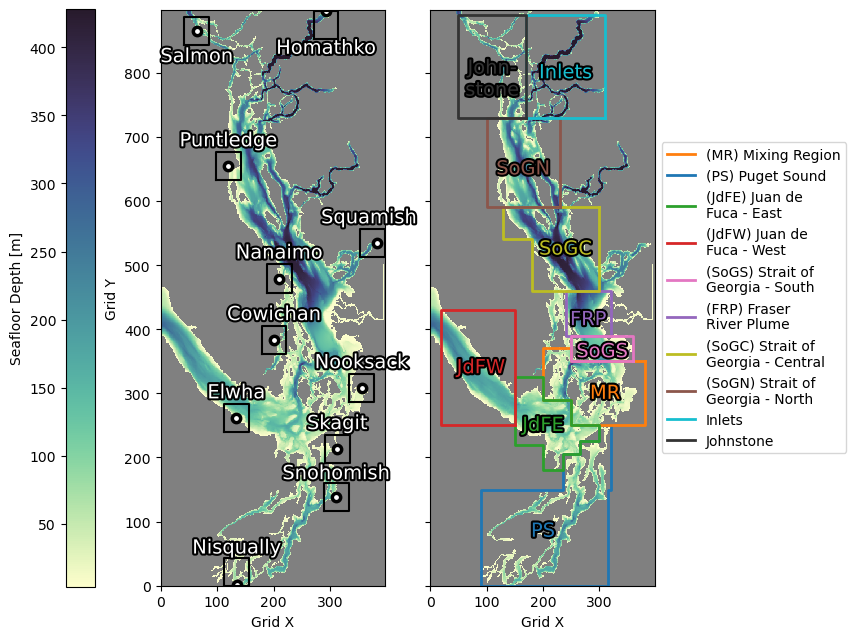

In [152]:
box_size = 22

fig, ax = plt.subplots(1, 2, figsize=(8.5, 7.5), sharex=True, sharey=True)
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax[0].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
cb = fig.colorbar(colours, ax=ax[:], orientation='vertical', location='left', label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax[0]);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax[0], Nooksack, 'k')
plot_point('fraser', 'Nooksack', ax[0])
river_text('fraser', 'Nooksack', 'Nooksack', ax[0], 'above', 0, 0)

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax[0], Skagit, 'k')
plot_point('skagit', 'Skagit1', ax[0])
river_text('skagit', 'Skagit1', 'Skagit', ax[0], 'above', 0, 0)

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax[0], Snohomish, 'k')
plot_point('skagit', 'SnohomishAllenQuilceda', ax[0])
river_text('skagit', 'SnohomishAllenQuilceda', 'Snohomish', ax[0], 'above', 0, -3)

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax[0], Nisqually, 'k')
plot_point('puget', 'NisquallyMcAllister', ax[0])
river_text('puget', 'NisquallyMcAllister', 'Nisqually', ax[0], 'above', 0, 18)

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax[0], Elwha, 'k')
plot_point('jdf', 'Elwha', ax[0])
river_text('jdf', 'Elwha', 'Elwha', ax[0], 'above', 0, 0)

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax[0], Cowichan, 'k')
plot_point('evi_s', 'Cowichan1', ax[0])
river_text('evi_s', 'Cowichan1', 'Cowichan', ax[0], 'above', 0, 0)

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax[0], Nanaimo, 'k')
plot_point('evi_s', 'Nanaimo1', ax[0])
river_text('evi_s', 'Nanaimo1', 'Nanaimo', ax[0], 'above', 0, 0)

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax[0], Puntledge, 'k')
plot_point('evi_s', 'Puntledge', ax[0])
river_text('evi_s', 'Puntledge', 'Puntledge', ax[0], 'above', 0, 0)

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax[0], Salmon, 'k')
plot_point('evi_n', 'SalmonSayward', ax[0])
river_text('evi_n', 'SalmonSayward', 'Salmon', ax[0], 'below', 0, 0)

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax[0], Homathko, 'k')
plot_point('bute', 'Homathko', ax[0])
river_text('bute', 'Homathko', 'Homathko', ax[0], 'below', 0, -18)

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax[0], Squamish, 'k')
plot_point('howe', 'Squamish', ax[0])
river_text('howe', 'Squamish', 'Squamish', ax[0], 'above', -15, 0)

boxcalls = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish']

## regions
tablist_nogrey = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', '#333333']
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax[1].pcolormesh(bathy['Bathymetry'], cmap=mycmap)
# cb = fig.colorbar(colours, ax=ax[1], label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax[1]);

## Puget Sound
puget_sound_poly = create_exact_outline(PS_all)
plot_poly(ax[1], puget_sound_poly, tablist_nogrey[0])
region_text(200, 85, 'PS', ax[1], tablist_nogrey[0])

## Mixing Region
MR_poly = create_exact_outline(MR_all)
plot_poly(ax[1], MR_poly, tablist_nogrey[1])
region_text(310, 300, 'MR', ax[1], tablist_nogrey[1])

## Juan de Fuca
JdFE_poly = create_exact_outline(JdFE_all)
plot_poly(ax[1], JdFE_poly, tablist_nogrey[2])
region_text(200, 250, 'JdFE', ax[1], tablist_nogrey[2])

JdFW_poly = create_exact_outline(JdFW_all)
plot_poly(ax[1], JdFW_poly, tablist_nogrey[3])
region_text(90, 340, 'JdFW', ax[1], tablist_nogrey[3])

## Fraser River Plume
FRP_poly = create_exact_outline(FRP_all)
plot_poly(ax[1], FRP_poly, tablist_nogrey[4])
region_text(280, 415, 'FRP', ax[1], tablist_nogrey[4])

## Strait of Georgia
SoGS_poly = create_exact_outline(SoGS_all)
plot_poly(ax[1], SoGS_poly, tablist_nogrey[6])
region_text(305, 365, 'SoGS', ax[1], tablist_nogrey[6])

SoGC_poly = create_exact_outline(SoGC_all)
plot_poly(ax[1], SoGC_poly, tablist_nogrey[7])
region_text(240, 525, 'SoGC', ax[1], tablist_nogrey[7])

SoGN_poly = create_exact_outline(SoGN_all)
plot_poly(ax[1], SoGN_poly, tablist_nogrey[5])
region_text(165, 650, 'SoGN', ax[1], tablist_nogrey[5])

## Northern Sounds
Inlets_poly = create_exact_outline(Inlets_all)
plot_poly(ax[1], Inlets_poly, tablist_nogrey[8])
region_text(240, 800, 'Inlets', ax[1], tablist_nogrey[8])

Johnstone_poly = create_exact_outline(Johnstone_all)
plot_poly(ax[1], Johnstone_poly, tablist_nogrey[9])
region_text(110, 790, 'John-\nstone', ax[1], tablist_nogrey[9])

ax[0].set_ylabel('Grid Y')
ax[0].set_xlabel('Grid X')

# ax[1].set_ylabel('Grid Y')
ax[1].set_xlabel('Grid X')

region_colors_dict = {'PS':tablist_nogrey[0], 'MR':tablist_nogrey[1], 'JdFW':tablist_nogrey[3], 'JdFE':tablist_nogrey[2], 'FRP':tablist_nogrey[4], 'SoGS':tablist_nogrey[6], 
                      'SoGC':tablist_nogrey[7], 'SoGN':tablist_nogrey[5], 'Inlets':tablist_nogrey[8], 'Johnstone':tablist_nogrey[9]
}

# order wanted: MR, PS, JdFE, JdFW, SoGS, FRP, SoGC, SoGN, SaS
custom_lines = [
    plt.Line2D([0], [0], color=region_colors_dict['MR'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['PS'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['JdFE'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['JdFW'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGS'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['FRP'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGC'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['SoGN'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['Inlets'], lw=2, linestyle='-'),
    plt.Line2D([0], [0], color=region_colors_dict['Johnstone'], lw=2, linestyle='-')
]
plt.legend(custom_lines, list(['(MR) Mixing Region', '(PS) Puget Sound', '(JdFE) Juan de\nFuca - East', \
                               '(JdFW) Juan de\nFuca - West', '(SoGS) Strait of\nGeorgia - South', '(FRP) Fraser\nRiver Plume', '(SoGC) Strait of\nGeorgia - Central', \
                                '(SoGN) Strait of\nGeorgia - North', 'Inlets', 'Johnstone']), loc='center left', bbox_to_anchor=(1, 0.5))

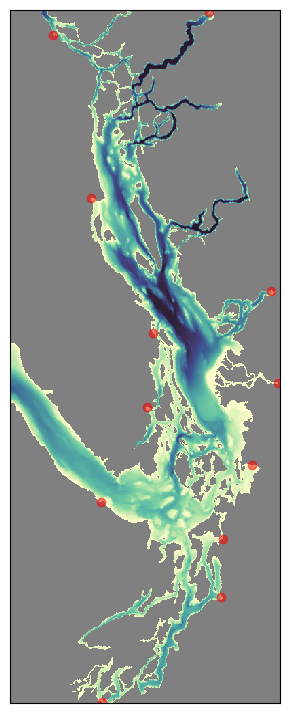

In [16]:
box_size = 22

fig, ax = plt.subplots(1, 1, figsize=(5, 9), sharey=True)
mycmap = cm.deep
mycmap.set_bad('grey')
colours = ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
# cb = fig.colorbar(colours, ax=ax, label=r'{}'.format('Seafloor Depth [m]'))
viz_tools.set_aspect(ax);
ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
#plot_box(ax, Nooksack, 'b')
plot_point('fraser', 'Nooksack', ax)

Skagit = river_box('skagit', 'Skagit1', box_size)
#plot_box(ax, Skagit, 'b')
plot_point('skagit', 'Skagit1', ax)

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
#plot_box(ax, Snohomish, 'b')
plot_point('skagit', 'SnohomishAllenQuilceda', ax)

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
#plot_box(ax, Nisqually, 'b')
plot_point('puget', 'NisquallyMcAllister', ax)

Elwha = river_box('jdf', 'Elwha', box_size)
#plot_box(ax, Elwha, 'b')
plot_point('jdf', 'Elwha', ax)

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
#plot_box(ax, Cowichan, 'b')
plot_point('evi_s', 'Cowichan1', ax)

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
#plot_box(ax, Nanaimo, 'b')
plot_point('evi_s', 'Nanaimo1', ax)

Puntledge = river_box('evi_s', 'Puntledge', box_size)
#plot_box(ax, Puntledge, 'b')
plot_point('evi_s', 'Puntledge', ax)

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
#plot_box(ax, Salmon, 'b')
plot_point('evi_n', 'SalmonSayward', ax)

Homathko = river_box('bute', 'Homathko', box_size)
#plot_box(ax, Homathko, 'b')
plot_point('bute', 'Homathko', ax)

Squamish = river_box('howe', 'Squamish', box_size)
#plot_box(ax, Squamish, 'b')
plot_point('howe', 'Squamish', ax)

river_idx = [rivers.prop_dict['fraser']['Fraser']['i'], rivers.prop_dict['fraser']['Fraser']['j']]
ax.plot(river_idx[1], river_idx[0]-85, 'ro', alpha=0.5)

Nooksack


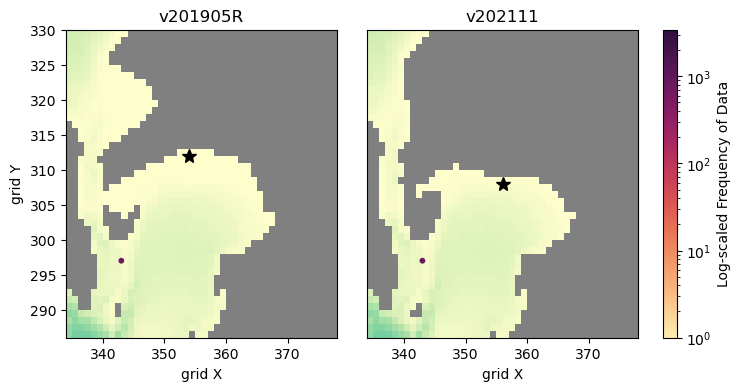

Skagit


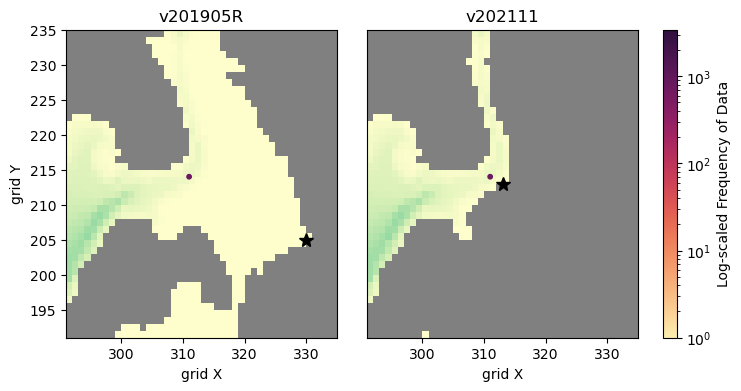

Snohomish


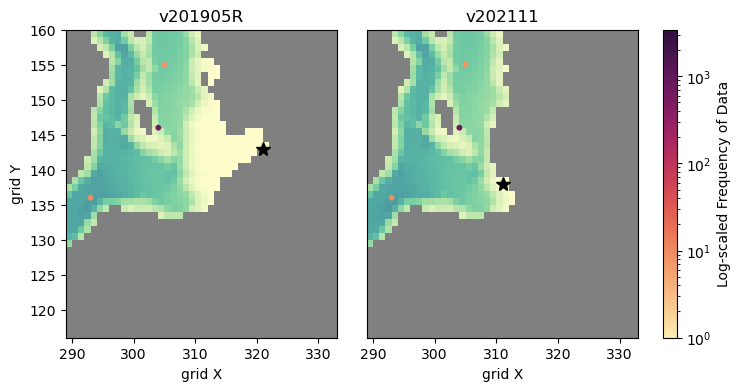

Nisqually


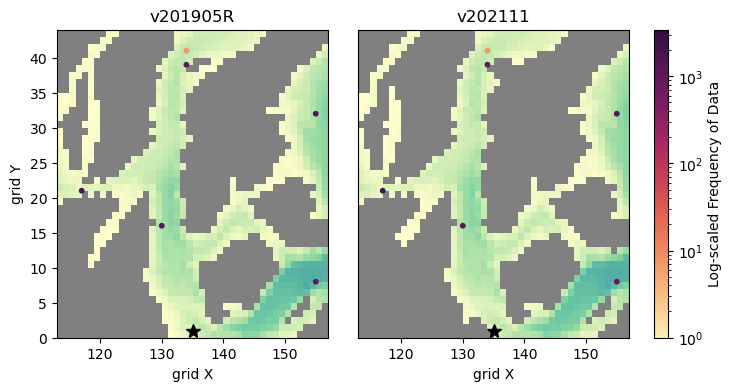

Elwha


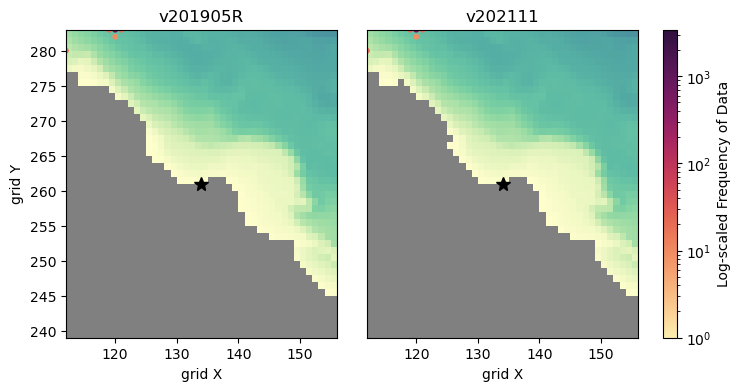

Cowichan


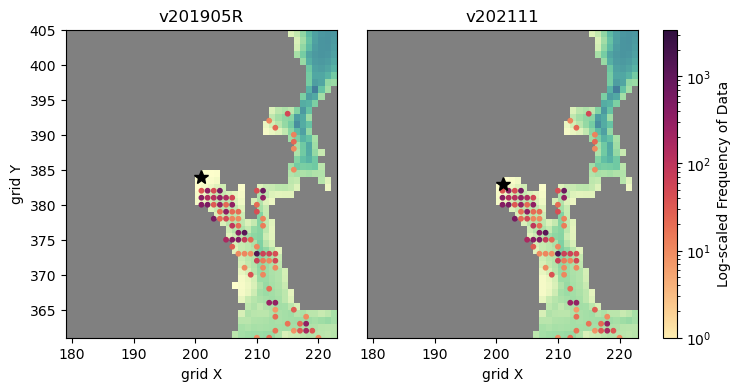

Nanaimo


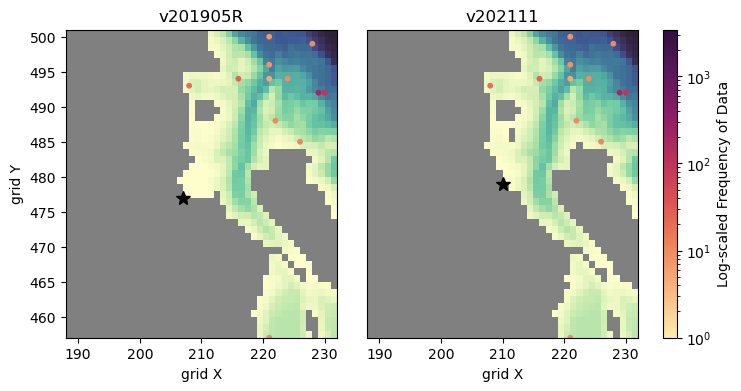

Puntledge


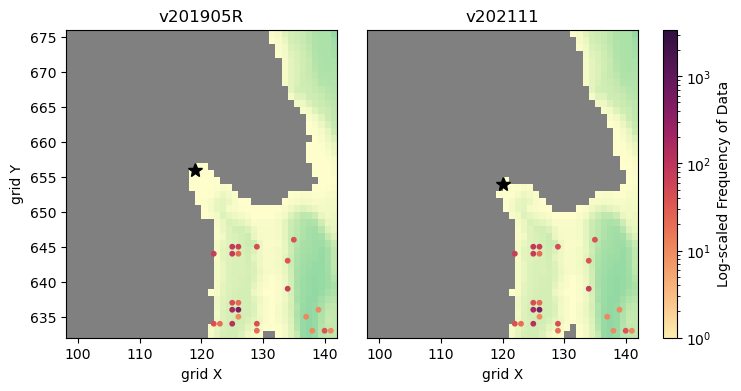

Salmon


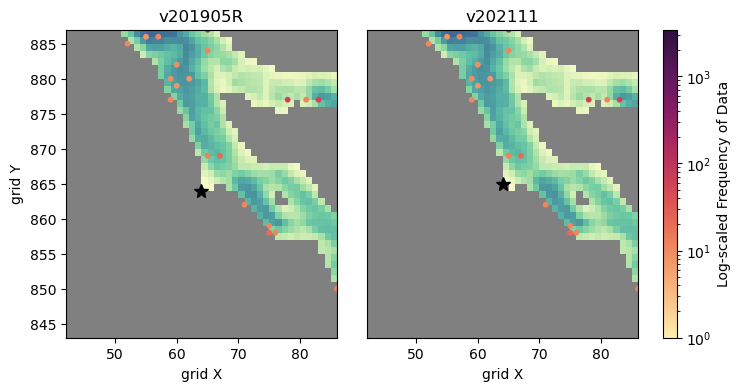

Homathko


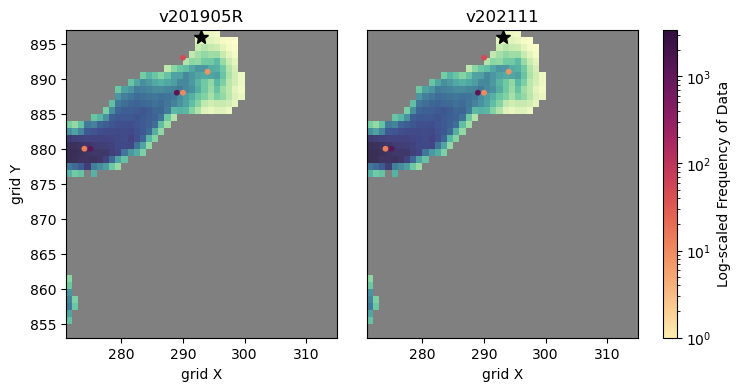

Squamish


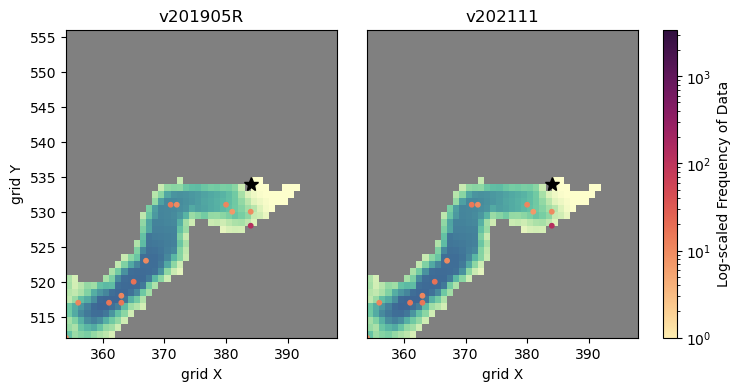

In [17]:
for boxname,boxcall in zip(boxnames,boxcalls):
    plot_bathy_and_data2(boxcall, boxname)

## Plotting try again

In [18]:
def plot_bathy_data_real1(boxname, boxcall):
    fix, ax = plt.subplots(1, 2, figsize=(7.5,3.5), sharex=True, sharey=True)
    fig.tight_layout(pad=1.2)

    cmap_bathy = cm.deep
    cmap_bathy.set_bad('grey')

    point2 = river_point(river_dict[boxcall]['wshed'], river_dict[boxcall]['call'], old=True)
    point = river_point(river_dict[boxcall]['wshed'], river_dict[boxcall]['call'], old=False)

    bathy2_cut = bathy2['Bathymetry'].sel(y=slice(boxname[0], boxname[1]+1), x=slice(boxname[2], boxname[3]+1))
    bathy2_cut = bathy2_cut.assign_coords(x=np.arange(boxname[2], boxname[3]+1), y=np.arange(boxname[0], boxname[1]+1))
    bathy_cut = bathy['Bathymetry'].sel(y=slice(boxname[0], boxname[1]+1), x=slice(boxname[2], boxname[3]+1))
    bathy_cut = bathy_cut.assign_coords(x=np.arange(boxname[2], boxname[3]+1), y=np.arange(boxname[0], boxname[1]+1))

    ## old bathy
    bathy2_color = ax[0].pcolormesh(bathy2_cut.x, bathy2_cut.y, bathy2_cut, cmap=mycmap, vmin=0)
    ax[0].set_ylim(boxname[0], boxname[1])
    ax[0].set_xlim(boxname[2], boxname[3])
    ax[0].plot(point2[1], point2[0], 'k*', markersize=10)
    ax[0].set_ylabel('Grid Y')
    ax[0].set_xlabel('Grid X')
    scatter1 = ax[0].scatter(df['i'], df['j'], s=15, c='tab:red')
    viz_tools.set_aspect(ax[0])

    ## new bathy
    ax[1].pcolormesh(bathy_cut.x, bathy_cut.y, bathy_cut, cmap=mycmap, vmin=0)
    ax[1].set_xlim(boxname[2], boxname[3])
    ax[1].set_ylim(boxname[0], boxname[1])
    ax[1].plot(point[1], point[0], 'k*', markersize=10)
    ax[1].set_xlabel('Grid X')
    scatter2 = ax[1].scatter(df['i'], df['j'], s=15, c='tab:red')
    viz_tools.set_aspect(ax[1])

    cb2 = fig.colorbar(bathy2_color, ax=ax[:], label=r'Seafloor Depth [m]')

    legend_elements = [
        Line2D([0], [0], marker='*', color='black', markersize=7, linestyle='None', label='{} Riv.'.format(boxcall)),
        Line2D([0], [0], marker='o', color='tab:red', markersize=4, linestyle='None', label='Obs. Stn.')
    ]
    ax[1].legend(handles=legend_elements, loc='lower right')

    point_number = df[(df['i'] >= boxname[2]) & (df['i'] <= boxname[3]) & (df['j'] >= boxname[0]) & (df['j'] <= boxname[1])]['count'].sum()
    print(point_number)


In [19]:
def plot_bathy_data_real2(boxname, boxcall):
    fix, ax = plt.subplots(1, 2, figsize=(7.5,3.5), sharex=True, sharey=True)
    fig.tight_layout(pad=1.2)

    cmap_bathy = cm.deep
    cmap_bathy.set_bad('grey')

    point2 = river_point(river_dict[boxcall]['wshed'], river_dict[boxcall]['call'], old=True)
    point = river_point(river_dict[boxcall]['wshed'], river_dict[boxcall]['call'], old=False)

    bathy2_cut = bathy2['Bathymetry'].sel(y=slice(boxname[0], boxname[1]+1), x=slice(boxname[2], boxname[3]))
    bathy2_cut = bathy2_cut.assign_coords(x=np.arange(boxname[2], boxname[3]), y=np.arange(boxname[0], boxname[1]+1))
    bathy_cut = bathy['Bathymetry'].sel(y=slice(boxname[0], boxname[1]+1), x=slice(boxname[2], boxname[3]))
    bathy_cut = bathy_cut.assign_coords(x=np.arange(boxname[2], boxname[3]), y=np.arange(boxname[0], boxname[1]+1))

    ## old bathy
    bathy2_color = ax[0].pcolormesh(bathy2_cut.x, bathy2_cut.y, bathy2_cut, cmap=mycmap, vmin=0)
    ax[0].set_ylim(boxname[0], boxname[1])
    ax[0].set_xlim(boxname[2], boxname[3]-1)
    ax[0].plot(point2[1], point2[0], 'k*', markersize=10)
    ax[0].set_ylabel('Grid Y')
    ax[0].set_xlabel('Grid X')
    scatter1 = ax[0].scatter(df['i'], df['j'], s=15, c='tab:red')
    viz_tools.set_aspect(ax[0])

    ## new bathy
    ax[1].pcolormesh(bathy_cut.x, bathy_cut.y, bathy_cut, cmap=mycmap, vmin=0)
    ax[1].set_xlim(boxname[2], boxname[3]-1)
    ax[1].set_ylim(boxname[0], boxname[1])
    ax[1].plot(point[1], point[0], 'k*', markersize=10)
    ax[1].set_xlabel('Grid X')
    scatter2 = ax[1].scatter(df['i'], df['j'], s=15, c='tab:red')
    viz_tools.set_aspect(ax[1])

    cb2 = fig.colorbar(bathy2_color, ax=ax[:], label=r'Seafloor Depth [m]')

    legend_elements = [
        Line2D([0], [0], marker='*', color='black', markersize=7, linestyle='None', label='{} Riv.'.format(boxcall)),
        Line2D([0], [0], marker='o', color='tab:red', markersize=4, linestyle='None', label='Obs. Stn.')
    ]
    ax[1].legend(handles=legend_elements, loc='upper left')

    point_number = df[(df['i'] >= boxname[2]) & (df['i'] <= boxname[3]) & (df['j'] >= boxname[0]) & (df['j'] <= boxname[1])]['count'].sum()
    print(point_number)

822


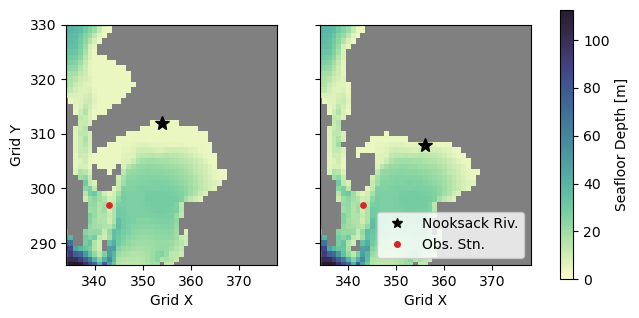

In [20]:
plot_bathy_data_real1(Nooksack,'Nooksack')

806


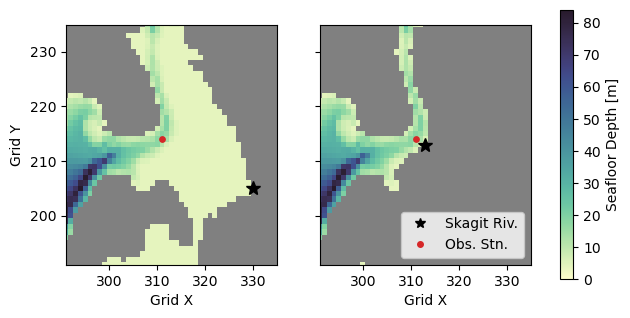

In [21]:
plot_bathy_data_real1(Skagit,'Skagit')

812


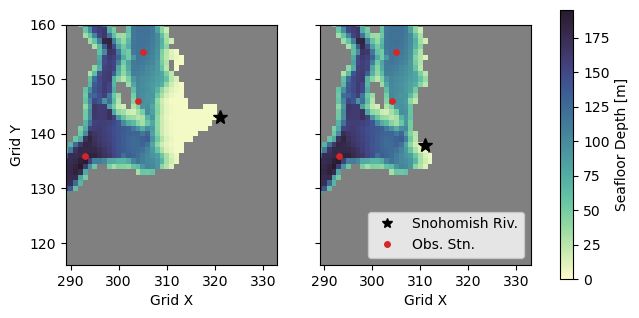

In [22]:
plot_bathy_data_real1(Snohomish,'Snohomish')

6615


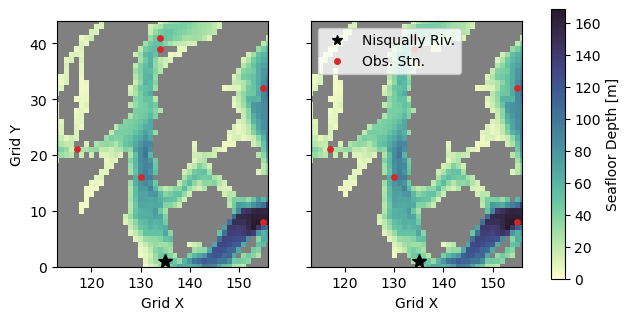

In [23]:
plot_bathy_data_real2(Nisqually,'Nisqually')

655


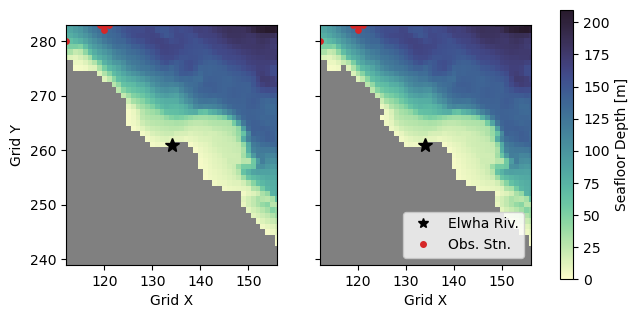

In [24]:
plot_bathy_data_real1(Elwha,'Elwha')

12264


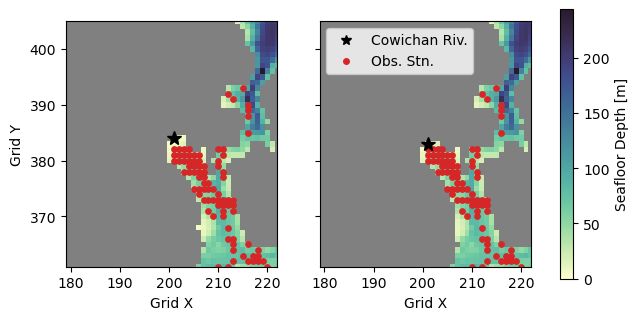

In [25]:
plot_bathy_data_real2(Cowichan,'Cowichan')

401


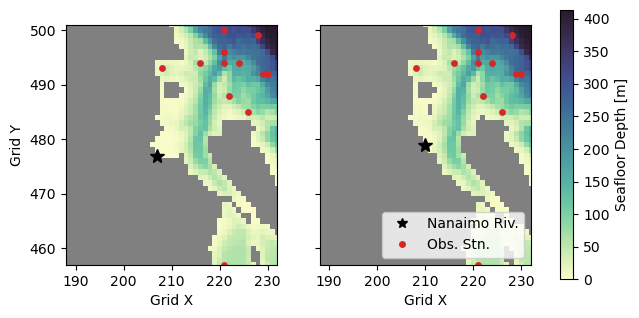

In [26]:
plot_bathy_data_real1(Nanaimo,'Nanaimo')

1573


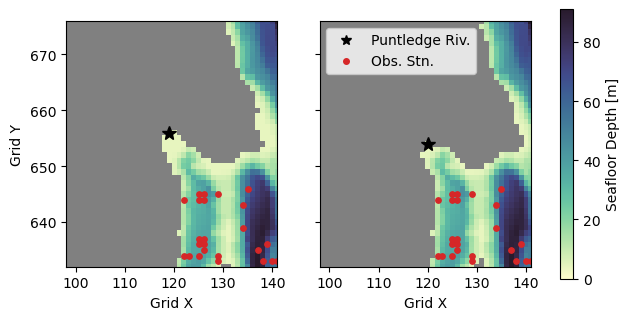

In [27]:
plot_bathy_data_real2(Puntledge,'Puntledge')

439


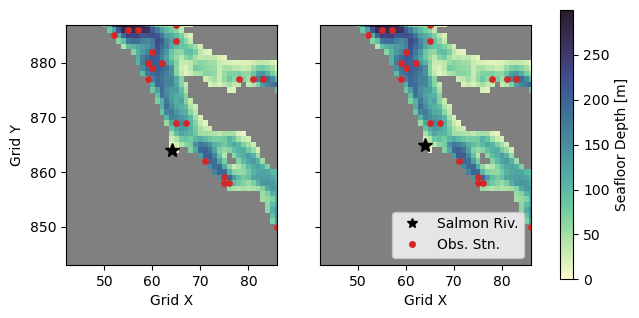

In [28]:
plot_bathy_data_real1(Salmon,'Salmon')

2504


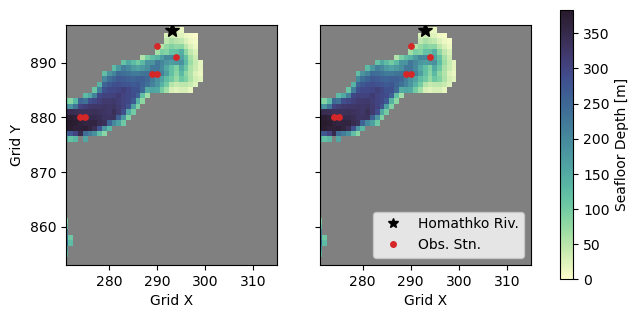

In [29]:
plot_bathy_data_real1(Homathko,'Homathko')

271


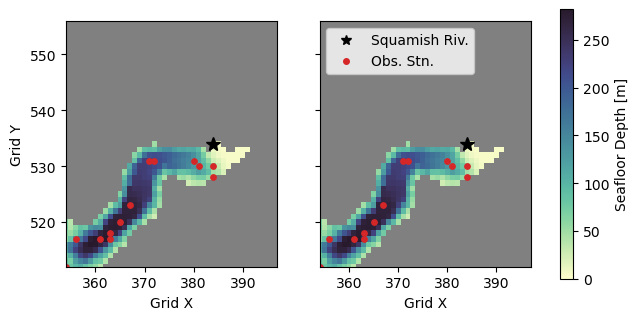

In [30]:
plot_bathy_data_real2(Squamish,'Squamish')

### Special for thesis with salinity

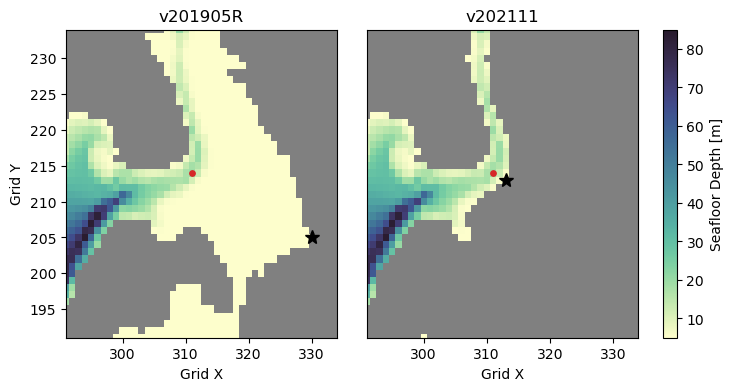

In [31]:
fig = plt.figure(figsize=(8.5, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)  # third spec is for the colorbar

bathy2_cut = bathy2['Bathymetry'].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))
bathy2_cut = bathy2_cut.assign_coords(x=np.arange(Skagit[2], Skagit[3]), y=np.arange(Skagit[0], Skagit[1]))
bathy_cut = bathy['Bathymetry'].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))
bathy_cut = bathy_cut.assign_coords(x=np.arange(Skagit[2], Skagit[3]), y=np.arange(Skagit[0], Skagit[1]))

# Plot for v201905R (left subplot)
ax0 = fig.add_subplot(gs[0, 0])
point2 = river_point(river_dict['Skagit']['wshed'], river_dict['Skagit']['call'], old=True)
mycmap = cm.deep
mycmap.set_bad('grey')
bathy2_color = ax0.pcolormesh(bathy2_cut.x, bathy2_cut.y, bathy2_cut, cmap=mycmap, vmin=5, vmax=85)
ax0.set_ylim(Skagit[0], Skagit[1]-1)
ax0.set_xlim(Skagit[2], Skagit[3]-1)
ax0.plot(point2[1], point2[0], 'k*', markersize=10)
ax0.set_title('v201905R')
ax0.set_ylabel('Grid Y')
ax0.set_xlabel('Grid X')
scatter1 = ax0.scatter(df['i'], df['j'], s=15, c='tab:red')
viz_tools.set_aspect(ax0)

# Plot for v202111 (right subplot)
ax1 = fig.add_subplot(gs[0, 1])
point = river_point(river_dict['Skagit']['wshed'], river_dict['Skagit']['call'], old=False)
ax1.pcolormesh(bathy_cut.x, bathy_cut.y, bathy_cut, cmap=mycmap, vmin=5, vmax=85)
ax1.set_xlim(Skagit[2], Skagit[3]-1)
ax1.set_ylim(Skagit[0], Skagit[1]-1)
ax1.plot(point[1], point[0], 'k*', markersize=10)
ax1.set_title('v202111')
ax1.set_yticks([])
# ax1.set_ylabel('Grid Y')
ax1.set_xlabel('Grid X')
scatter2 = ax1.scatter(df['i'], df['j'], s=15, c='tab:red')
viz_tools.set_aspect(ax1)

# Add the colorbar on the far right without resizing the subplots
cax = fig.add_subplot(gs[0, 2])
cbar = plt.colorbar(bathy2_color, cax=cax)
cbar.set_label('Seafloor Depth [m]')

# Manually adjust layout
plt.subplots_adjust(right=0.85)  # Adjust right margin to fit colorbar

In [32]:
phys_2022_jun = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_{}0101_{}1231.nc'.format(2022, 2022)).isel(depth=0, time=5)

In [33]:
phys_2022_jun_old = xr.open_dataset('/results2/SalishSea/month-avg.201905/SalishSeaCast_1m_grid_T_20220601_20220630.nc').isel(depth=0, time=0)

In [34]:
phys_2022_jun

<xarray.Dataset>
Dimensions:   (gridY: 898, gridX: 398)
Coordinates:
    depth     float32 0.5
  * gridY     (gridY) int64 0 1 2 3 4 5 6 7 ... 890 891 892 893 894 895 896 897
  * gridX     (gridX) int64 0 1 2 3 4 5 6 7 ... 390 391 392 393 394 395 396 397
    time      datetime64[ns] 2022-06-15
Data variables:
    votemper  (gridY, gridX) float32 ...
    vosaline  (gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_20220101...
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2024-05-29 13:44 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [35]:
mesh2 = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask2 = 1 - mesh2.tmask[0]

/tmp/ipykernel_1599385/4037202878.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.2)


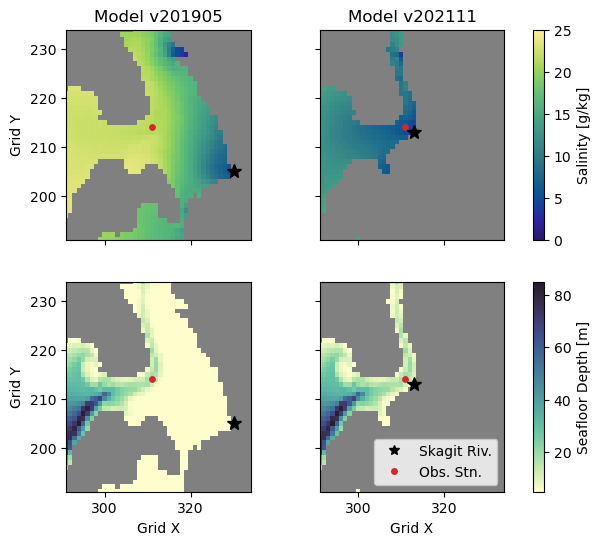

In [36]:
fix, ax = plt.subplots(2, 2, figsize=(7.5,6), sharex=True, sharey=True)
fig.tight_layout(pad=1.2)

cmap_sal = cm.haline
cmap_sal.set_bad('gray')

tmask_202111 = tmask[0].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))
tmask_201905 = tmask2[0].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))

jun_sal = phys_2022_jun.vosaline.sel(gridY=slice(Skagit[0], Skagit[1]-1), gridX=slice(Skagit[2], Skagit[3]-1))
jun_sal_old = phys_2022_jun_old.vosaline.sel(gridY=slice(Skagit[0], Skagit[1]-1), gridX=slice(Skagit[2], Skagit[3]-1))

## old sal
colors_00 = ax[0,0].pcolormesh(jun_sal_old.gridX, jun_sal_old.gridY, np.ma.masked_array(jun_sal_old, tmask_201905), cmap=cmap_sal, vmin=0, vmax=25)
ax[0,0].set_ylim(Skagit[0], Skagit[1]-1)
ax[0,0].set_xlim(Skagit[2], Skagit[3]-1)
ax[0,0].set_ylabel('Grid Y')
ax[0,0].set_title('Model v201905')
viz_tools.set_aspect(ax[0,0])
ax[0,0].scatter(df['i'], df['j'], s=15, c='tab:red')
ax[0,0].plot(point2[1], point2[0], 'k*', markersize=10)

## new sal
colors_01 = ax[0,1].pcolormesh(jun_sal.gridX, jun_sal.gridY, np.ma.masked_array(jun_sal, tmask_202111), cmap=cmap_sal, vmin=0, vmax=25)
ax[0,1].set_ylim(Skagit[0], Skagit[1]-1)
ax[0,1].set_xlim(Skagit[2], Skagit[3]-1)
ax[0,1].set_title('Model v202111')
viz_tools.set_aspect(ax[0,1])
ax[0,1].scatter(df['i'], df['j'], s=15, c='tab:red')
ax[0,1].plot(point[1], point[0], 'k*', markersize=10)

cb = fig.colorbar(colors_00, ax=ax[0,:], label=r'Salinity [g/kg]')

cmap_bathy = cm.deep
cmap_bathy.set_bad('grey')

point2 = river_point(river_dict['Skagit']['wshed'], river_dict['Skagit']['call'], old=True)
point = river_point(river_dict['Skagit']['wshed'], river_dict['Skagit']['call'], old=False)

bathy2_cut = bathy2['Bathymetry'].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))
bathy2_cut = bathy2_cut.assign_coords(x=np.arange(Skagit[2], Skagit[3]), y=np.arange(Skagit[0], Skagit[1]))
bathy_cut = bathy['Bathymetry'].sel(y=slice(Skagit[0], Skagit[1]), x=slice(Skagit[2], Skagit[3]))
bathy_cut = bathy_cut.assign_coords(x=np.arange(Skagit[2], Skagit[3]), y=np.arange(Skagit[0], Skagit[1]))

## old bathy
bathy2_color = ax[1,0].pcolormesh(bathy2_cut.x, bathy2_cut.y, bathy2_cut, cmap=mycmap, vmin=5, vmax=85)
ax[1,0].set_ylim(Skagit[0], Skagit[1]-1)
ax[1,0].set_xlim(Skagit[2], Skagit[3]-1)
ax[1,0].plot(point2[1], point2[0], 'k*', markersize=10)
ax[1,0].set_ylabel('Grid Y')
ax[1,0].set_xlabel('Grid X')
scatter1 = ax[1,0].scatter(df['i'], df['j'], s=15, c='tab:red')
viz_tools.set_aspect(ax[1,0])

## new bathy
ax[1,1].pcolormesh(bathy_cut.x, bathy_cut.y, bathy_cut, cmap=mycmap, vmin=5, vmax=85)
ax[1,1].set_xlim(Skagit[2], Skagit[3]-1)
ax[1,1].set_ylim(Skagit[0], Skagit[1]-1)
ax[1,1].plot(point[1], point[0], 'k*', markersize=10)
ax[1,1].set_xlabel('Grid X')
scatter2 = ax[1,1].scatter(df['i'], df['j'], s=15, c='tab:red')
viz_tools.set_aspect(ax[1,1])

cb2 = fig.colorbar(bathy2_color, ax=ax[1,:], label=r'Seafloor Depth [m]')

legend_elements = [
    Line2D([0], [0], marker='*', color='black', markersize=7, linestyle='None', label='Skagit Riv.'),
    Line2D([0], [0], marker='o', color='tab:red', markersize=4, linestyle='None', label='Obs. Stn.')
]
ax[1,1].legend(handles=legend_elements, loc='lower right')


In [37]:
df[(df['i'] >= Skagit[2]) & (df['i'] <= Skagit[3]) & (df['j'] >= Skagit[0]) & (df['j'] <= Skagit[1])]

,i,j,count
1896,311,214,806


/tmp/ipykernel_1599385/380165672.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1.2)


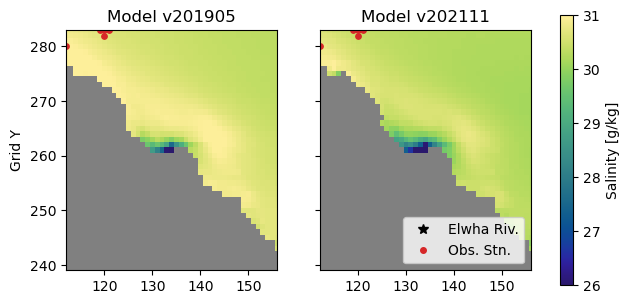

In [38]:
fix, ax = plt.subplots(1, 2, figsize=(7.5,3.5), sharex=True, sharey=True)
fig.tight_layout(pad=1.2)

cmap_sal = cm.haline
cmap_sal.set_bad('gray')

tmask_202111 = tmask[0].sel(y=slice(Elwha[0], Elwha[1]+1), x=slice(Elwha[2], Elwha[3]+1))
tmask_201905 = tmask2[0].sel(y=slice(Elwha[0], Elwha[1]+1), x=slice(Elwha[2], Elwha[3]+1))

jun_sal = phys_2022_jun.vosaline.sel(gridY=slice(Elwha[0], Elwha[1]), gridX=slice(Elwha[2], Elwha[3]))
jun_sal_old = phys_2022_jun_old.vosaline.sel(gridY=slice(Elwha[0], Elwha[1]), gridX=slice(Elwha[2], Elwha[3]))

## old sal
colors_00 = ax[0].pcolormesh(jun_sal_old.gridX, jun_sal_old.gridY, np.ma.masked_array(jun_sal_old, tmask_201905), cmap=cmap_sal, vmin=26, vmax=31)
ax[0].set_ylim(Elwha[0], Elwha[1])
ax[0].set_xlim(Elwha[2], Elwha[3])
ax[0].set_ylabel('Grid Y')
ax[0].set_title('Model v201905')
viz_tools.set_aspect(ax[0])
ax[0].scatter(df['i'], df['j'], s=15, c='tab:red')
ax[0].plot(point2[1], point2[0], 'k*', markersize=10)

## new sal
colors_01 = ax[1].pcolormesh(jun_sal.gridX, jun_sal.gridY, np.ma.masked_array(jun_sal, tmask_202111), cmap=cmap_sal, vmin=26, vmax=31)
ax[1].set_ylim(Elwha[0], Elwha[1])
ax[1].set_xlim(Elwha[2], Elwha[3])
ax[1].set_title('Model v202111')
viz_tools.set_aspect(ax[1])
ax[1].scatter(df['i'], df['j'], s=15, c='tab:red')
ax[1].plot(point[1], point[0], 'k*', markersize=10)

cb = fig.colorbar(colors_00, ax=ax[:], label=r'Salinity [g/kg]')

cmap_bathy = cm.deep
cmap_bathy.set_bad('grey')

point2 = river_point(river_dict['Elwha']['wshed'], river_dict['Elwha']['call'], old=True)
point = river_point(river_dict['Elwha']['wshed'], river_dict['Elwha']['call'], old=False)

bathy2_cut = bathy2['Bathymetry'].sel(y=slice(Elwha[0], Elwha[1]), x=slice(Elwha[2], Elwha[3]))
bathy2_cut = bathy2_cut.assign_coords(x=np.arange(Elwha[2], Elwha[3]), y=np.arange(Elwha[0], Elwha[1]))
bathy_cut = bathy['Bathymetry'].sel(y=slice(Elwha[0], Elwha[1]), x=slice(Elwha[2], Elwha[3]))
bathy_cut = bathy_cut.assign_coords(x=np.arange(Elwha[2], Elwha[3]), y=np.arange(Elwha[0], Elwha[1]))

# ## old bathy
# bathy2_color = ax[1,0].pcolormesh(bathy2_cut.x, bathy2_cut.y, bathy2_cut, cmap=mycmap, vmin=25, vmax=200)
# ax[1,0].set_ylim(Elwha[0], Elwha[1]-1)
# ax[1,0].set_xlim(Elwha[2], Elwha[3]-1)
# ax[1,0].plot(point2[1], point2[0], 'k*', markersize=10)
# ax[1,0].set_ylabel('Grid Y')
# ax[1,0].set_xlabel('Grid X')
# scatter1 = ax[1,0].scatter(df['i'], df['j'], s=15, c='tab:red')
# viz_tools.set_aspect(ax[1,0])

# ## new bathy
# ax[1,1].pcolormesh(bathy_cut.x, bathy_cut.y, bathy_cut, cmap=mycmap, vmin=25, vmax=200)
# ax[1,1].set_xlim(Elwha[2], Elwha[3]-1)
# ax[1,1].set_ylim(Elwha[0], Elwha[1]-1)
# ax[1,1].plot(point[1], point[0], 'k*', markersize=10)
# ax[1,1].set_xlabel('Grid X')
# scatter2 = ax[1,1].scatter(df['i'], df['j'], s=15, c='tab:red')
# viz_tools.set_aspect(ax[1,1])

# cb2 = fig.colorbar(bathy2_color, ax=ax[1,:], label=r'Seafloor Depth [m]')

legend_elements = [
    Line2D([0], [0], marker='*', color='black', markersize=7, linestyle='None', label='Elwha Riv.'),
    Line2D([0], [0], marker='o', color='tab:red', markersize=4, linestyle='None', label='Obs. Stn.')
]
ax[1].legend(handles=legend_elements, loc='lower right')

In [39]:
df[(df['i'] >= Elwha[2]) & (df['i'] <= Elwha[3]) & (df['j'] >= Elwha[0]) & (df['j'] <= Elwha[1])]['count'].sum()

655

### frequency

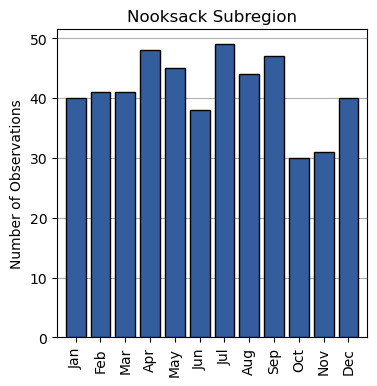

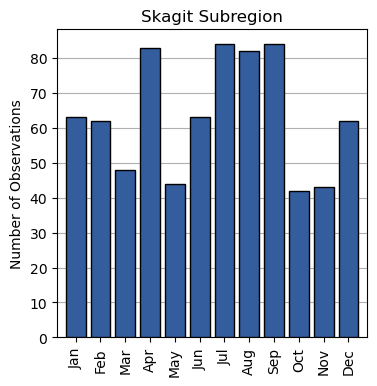

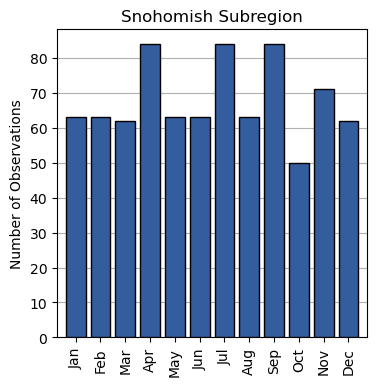

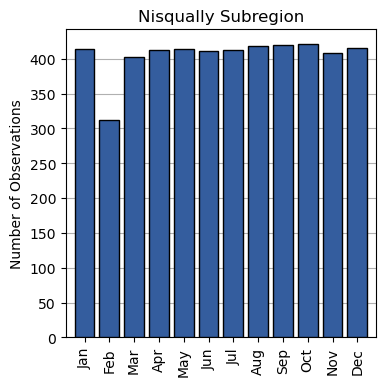

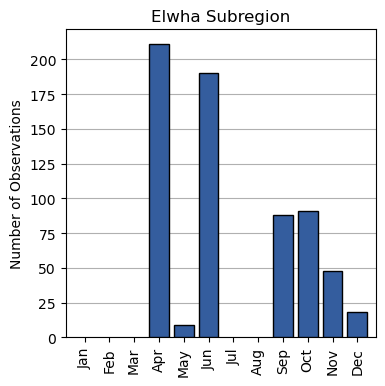

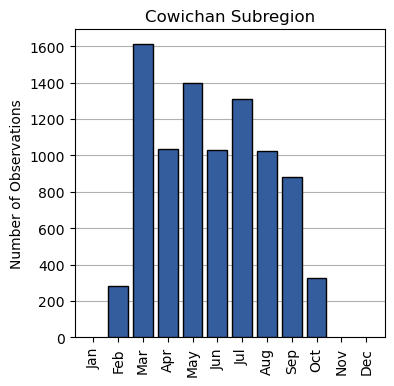

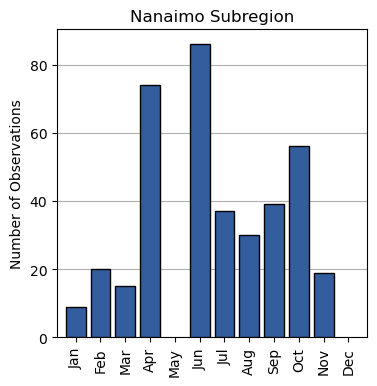

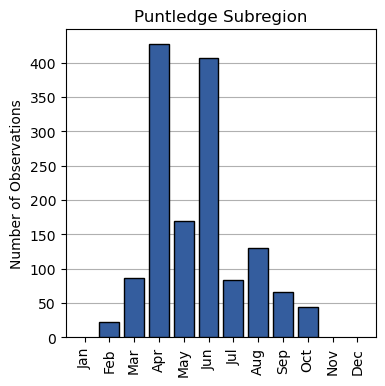

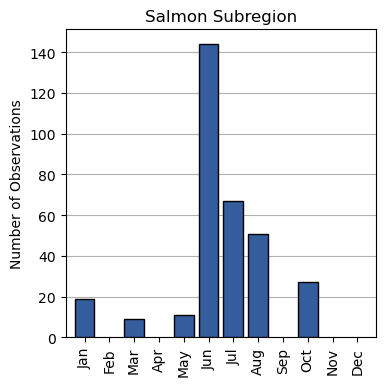

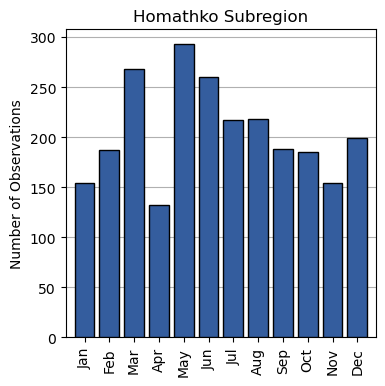

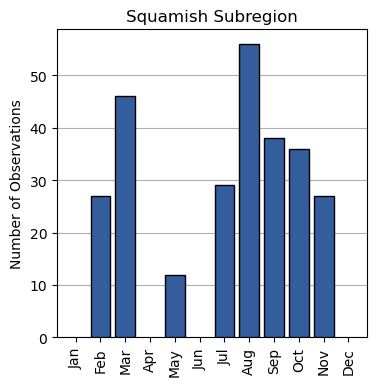

In [40]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
all_months = pd.DataFrame({'Month': range(1, 13)})

for idx in np.arange(len(boxcalls)):
    fig, ax = plt.subplots(1,1, figsize=(4,4))

    select = temp1[(temp1.k >= 0) & (temp1.k <= 10) &
                        (temp1.j >= boxcalls[idx][0]) & (temp1.j <= boxcalls[idx][1]) &
                        (temp1.i >= boxcalls[idx][2]) & (temp1.i <= boxcalls[idx][3])]
    months_df = select.groupby(['Month']).size().reset_index(name='count')
    merged_df = pd.merge(all_months, months_df, on='Month', how='left')
    merged_df['count'] = merged_df['count'].fillna(0)
    merged_df['count'] = merged_df['count'].astype(int)
    ax.grid(axis='y', which='major', zorder=0)
    ax.bar(months_df['Month'], months_df['count'], color=color3, edgecolor='k', zorder=3)
    ax.set_xlim([0.25,12.75])
    ax.set_title('{} Subregion'.format(boxnames[idx]))
    ax.set_xticks(all_months['Month'].values)
    ax.set_xticklabels(months, rotation=90)
    ax.set_ylabel('Number of Observations')

## Rivers

In [41]:
river_keys = ['nooksack_river',\
 'skagit_river',\
 'snohomish_river',\
 'nisqually_river',\
 'elwha_river',\
 'cowichan_river',\
 'nanaimo_river',\
 'puntledge_river',\
 'salmon_river',\
 'homathko_river',\
 'squamish_river',\
 'fraser_river',\
 'other_rivers']

In [42]:
rainbow_bright = ['#D20000', '#FF7C00', '#FFB600', '#6DCA13', '#44C3D0', '#283BD0', '#B62AD4']
rainbow_muted = ['#7D0404', '#AB5503', '#396B09', '#277780', '#151E67', '#561265']
colors_list8 = rainbow_bright + rainbow_muted
lines_list8 = ['-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']

In [43]:
rcolor_order = river_keys + ['other_rivers']
rcolor_dict = dict(zip(rcolor_order, colors_list8))

In [44]:
river_names = {'fraser_river': 'Fraser', 'nooksack_river': 'Nooksack', 'skagit_river': 'Skagit', 'snohomish_river': 'Snohomish', \
              'nisqually_river': 'Nisqually', 'elwha_river': 'Elwha', 'cowichan_river': 'Cowichan', \
              'nanaimo_river': 'Nanaimo', 'puntledge_river': 'Puntledge', 'salmon_river': 'Salmon', 'homathko_river': 'Homathko', \
              'squamish_river': 'Squamish'}

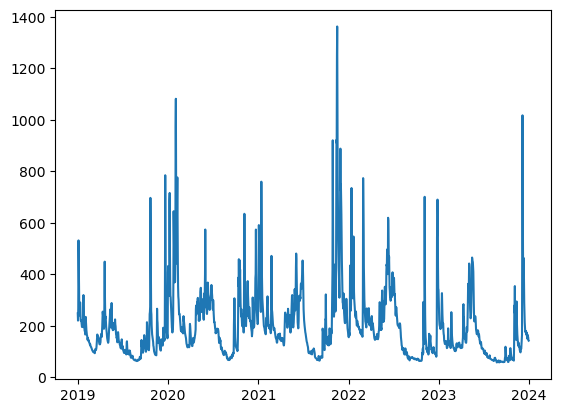

In [45]:
river_dict = {'fraser_river': 'Fraser [m^3/s]', 'nooksack_river': 'Nooksack [m^3/s]', 'skagit_river': 'Skagit1 [m^3/s]', 'snohomish_river': 'SnohomishAllenQuilceda [m^3/s]', \
              'nisqually_river': 'NisquallyMcAllister [m^3/s]', 'elwha_river': 'Elwha [m^3/s]', 'cowichan_river': 'Cowichan1 [m^3/s]', \
              'nanaimo_river': 'Nanaimo1 [m^3/s]', 'puntledge_river': 'Puntledge [m^3/s]', 'salmon_river': 'SalmonSayward [m^3/s]', 'homathko_river': 'Homathko [m^3/s]', \
              'squamish_river': 'Squamish [m^3/s]'}

river_flows_202108 = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/river_dailies_to_vol_ts_all12_20190101_20231231.csv')
river_flows_202108 = river_flows_202108.loc[:, river_flows_202108.columns != 'Unnamed: 0']

river_flows_202108['date'] = pd.to_datetime(river_flows_202108['date'])
river_flows_202108['month'] = river_flows_202108['date'].dt.month
river_flows_202108['dayofyear'] = river_flows_202108['date'].dt.dayofyear
river_flows_202108['year'] = river_flows_202108['date'].dt.year
daily_clim_202108 = river_flows_202108.groupby(['dayofyear']).mean(numeric_only=True).reset_index()
# river_flows_202108

# river_flows_202108.loc[:, (river_flows_202108.columns != 'Unnamed: 0') & (river_flows_202108.columns != 'date') & (river_flows_202108.columns != 'month') & (river_flows_202108.columns != 'dayofyear')].plot()
plt.plot(river_flows_202108['date'], river_flows_202108['Skagit1 [m^3/s]'].values)
# plt.plot(daily_clim_202108['dayofyear'], daily_clim_202108['Skagit1 [m^3/s]'].values)

In [46]:
river_flows_202108['date']

0      2019-01-01
1      2019-01-02
2      2019-01-03
3      2019-01-04
4      2019-01-05
          ...    
1821   2023-12-27
1822   2023-12-28
1823   2023-12-29
1824   2023-12-30
1825   2023-12-31
Name: date, Length: 1826, dtype: datetime64[ns]

In [47]:
rainfall_keys = ['nooksack_river', 'elwha_river', 'cowichan_river', 'nanaimo_river', 'puntledge_river']
glacial_keys = ['homathko_river', 'squamish_river']
mixed_keys = ['skagit_river', 'snohomish_river', 'nisqually_river', 'salmon_river']
fras_key = ['fraser_river']

In [48]:
z_order_dict = {'elwha_river': 0, 'puntledge_river': 1, 'nooksack_river': 4, 'cowichan_river': 2, 'nanaimo_river': 3,\
                'snohomish_river': 0, 'skagit_river': 1, 'salmon_river': 2, 'nisqually_river': 3}

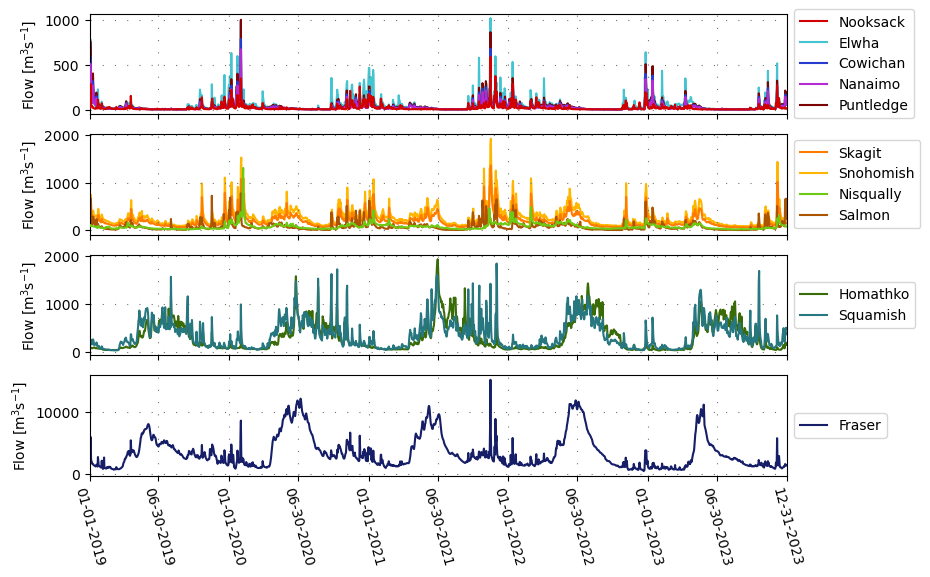

In [49]:
fig, ax = plt.subplots(4, 1, figsize=(9, 6), sharex=True)

tick_labels = ['2019-01-01', '2019-06-30', '2020-01-01', '2020-06-30',
               '2021-01-01', '2021-06-30', '2022-01-01', '2022-06-30',
               '2023-01-01', '2023-06-30', '2023-12-31']

tick_labels = pd.to_datetime(tick_labels)

for key in rainfall_keys:
    ax[0].plot(river_flows_202108['date'], river_flows_202108[river_dict[key]].values, label=river_names[key], color=rcolor_dict[key], linestyle='-', linewidth=1.5, alpha=1, zorder=z_order_dict[key])
    ax[0].grid(axis='both', color='#737373', linestyle=(0, (1, 10)))
    ax[0].set_ylabel(r'Flow [m$^3$s$^{-1}$]')
    ax[0].set_xlim([river_flows_202108['date'].min(), river_flows_202108['date'].max()])

for key in mixed_keys:
    ax[1].plot(river_flows_202108['date'], river_flows_202108[river_dict[key]].values, label=river_names[key], color=rcolor_dict[key], linestyle='-', linewidth=1.5, alpha=1, zorder=z_order_dict[key])
    ax[1].grid(axis='both', color='#737373', linestyle=(0, (1, 10)))
    ax[1].set_ylabel(r'Flow [m$^3$s$^{-1}$]')
    ax[1].set_xlim([river_flows_202108['date'].min(), river_flows_202108['date'].max()])

for key in glacial_keys:
    ax[2].plot(river_flows_202108['date'], river_flows_202108[river_dict[key]].values, label=river_names[key], color=rcolor_dict[key], linestyle='-', linewidth=1.5, alpha=1)
    ax[2].grid(axis='both', color='#737373', linestyle=(0, (1, 10)))
    ax[2].set_ylabel(r'Flow [m$^3$s$^{-1}$]')
    ax[2].set_xlim([river_flows_202108['date'].min(), river_flows_202108['date'].max()])

for key in fras_key:
    ax[3].plot(river_flows_202108['date'], river_flows_202108[river_dict[key]].values, label=river_names[key], color=rcolor_dict[key], linestyle='-', linewidth=1.5, alpha=1)
    ax[3].grid(axis='both', color='#737373', linestyle=(0, (1, 10)))
    ax[3].set_ylabel(r'Flow [m$^3$s$^{-1}$]')
    ax[3].set_xlim([river_flows_202108['date'].min(), river_flows_202108['date'].max()])

ax[3].set_xticks(tick_labels)
ax[3].set_xticklabels((tick_labels.strftime('%m-%d-%Y')))
ax[3].tick_params(axis='x', labelrotation=-75)

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [50]:
rainfall_flows = river_flows_202108[river_dict['elwha_river']].values + river_flows_202108[river_dict['nooksack_river']].values +\
river_flows_202108[river_dict['cowichan_river']].values + river_flows_202108[river_dict['nanaimo_river']].values +\
river_flows_202108[river_dict['puntledge_river']].values

for_percent_flows = rainfall_flows + river_flows_202108[river_dict['fraser_river']].values

In [51]:
## November-March
rainy_months = (river_flows_202108['date'].dt.month == 12) | (river_flows_202108['date'].dt.month == 1) | (river_flows_202108['date'].dt.month == 2)
# rainy_months = (river_flows_202108['date'].dt.month == 12) | (river_flows_202108['date'].dt.month == 1) | (river_flows_202108['date'].dt.month == 2) | (river_flows_202108['date'].dt.month == 11) | (river_flows_202108['date'].dt.month == 3)
## June-August
dry_months = (river_flows_202108['date'].dt.month == 6) | (river_flows_202108['date'].dt.month == 7) | (river_flows_202108['date'].dt.month == 8)
## Sept-Oct and April-May
no_ass_months = ~(rainy_months | dry_months)

In [52]:
rainy_avg = (rainfall_flows[rainy_months]/for_percent_flows[rainy_months]).mean()

In [53]:
dry_avg = (rainfall_flows[dry_months]/for_percent_flows[dry_months]).mean()

In [54]:
color_spring = '#7ABB00'
color_summer = '#FFBF00'
color_fall = '#FF6F00'
color_winter = '#00C6C9'

dark_color_spring = '#446900'
dark_color_summer = '#a17800'
dark_color_fall = '#964100'
dark_color_winter = '#01797a'

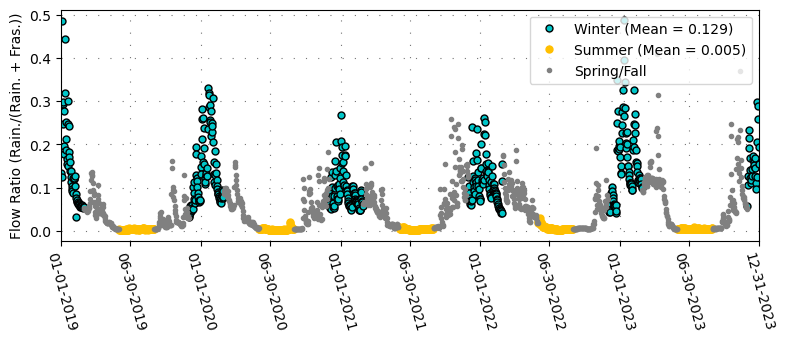

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(river_flows_202108['date'][rainy_months], rainfall_flows[rainy_months]/for_percent_flows[rainy_months], color=color_winter, marker='o', linestyle='', mec='k', markersize=5, label='Winter (Mean = {:.3f})'.format(rainy_avg))
ax.plot(river_flows_202108['date'][dry_months], rainfall_flows[dry_months]/for_percent_flows[dry_months], color=color_summer, marker='o', linestyle='', markersize=5, label='Summer (Mean = {:.3f})'.format(dry_avg))
ax.plot(river_flows_202108['date'][no_ass_months], rainfall_flows[no_ass_months]/for_percent_flows[no_ass_months], color='grey', marker='.', linestyle='', label='Spring/Fall')

ax.set_xlim([river_flows_202108['date'].min(), river_flows_202108['date'].max()])
ax.grid(axis='both', color='#737373', linestyle=(0, (1, 10)))

ax.set_xticks(tick_labels)
ax.set_xticklabels((tick_labels.strftime('%m-%d-%Y')))
ax.tick_params(axis='x', labelrotation=-75)
ax.set_ylabel(r'Flow Ratio (Rain./(Rain. + Fras.))')

ax.legend(loc='upper right')